In [1]:
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
from predict_next_token_in_time_series import *

# Generate data

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/predict_next_token_in_time_series.py:44: RuntimeWarning: invalid value encountered in sqrt
  return self.delta_sigma * np.sqrt(np.pi * a) * self.beta
/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/predict_next_token_in_time_series.py:48: RuntimeWarning: overflow encountered in power
  return self.C * (self.delta_K(a) ** self.m)


(np.float64(5.560583840149885e-07), np.float64(2.8707573761258507), (981, 100))

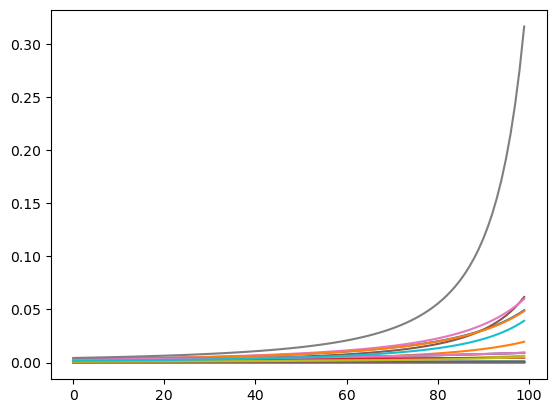

In [3]:
length = 100
n0 = 50
paris_episodes = np.empty((0, length))
for C in [1e-8, 3e-8, 5e-8, 7e-8, 8e-8]:
    for l0 in [0.0045, 0.003, 0.0015, 0.0007, 0.0001]:
        paris = ParisLawDegradation(length=length, dim=1, C=C)
        episodes_i = paris.generate_episode(x0=np.random.randn(n0)*0.0003+l0)  # Initial crack lengths in meters
        paris_episodes = np.concatenate([paris_episodes, episodes_i], axis=0)

#drop invalid values
paris_episodes = paris_episodes[~np.isnan(paris_episodes).any(axis=1)]
paris_episodes = paris_episodes[(paris_episodes<3).all(axis=1)]
paris_episodes = paris_episodes[(paris_episodes>=0).all(axis=1)]

paris_episodes.shape
# plot 20 random episodes
plt.plot(paris_episodes[np.random.randint(0, paris_episodes.shape[0], size=20)].T)
paris_episodes.min(), paris_episodes.max(), paris_episodes.shape

(np.float64(0.0003974787707515387), np.float64(2.9912121878944626), (490, 100))

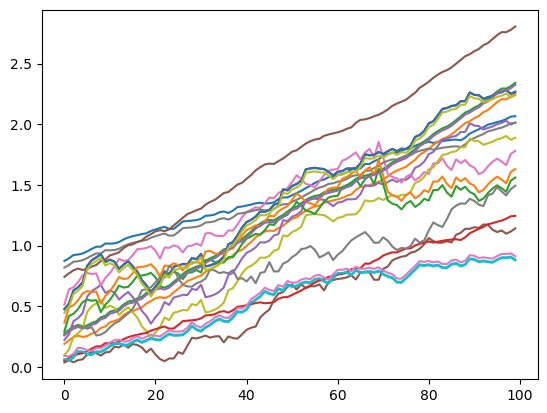

In [4]:
lin_episodes = np.empty((0, length))
for c in np.linspace(0.01, 0.05, 5):
    for sigma_e in np.linspace(0.01, 0.05, 5):
        lin = LinearDegradation(length=length, dim=1, c=c, mu_e=0, sigma_e=sigma_e)
        episodes_i = lin.generate_episode(x0=np.abs(np.random.randn(n0)*0.5))  # Initial crack lengths in meters
        lin_episodes = np.concatenate([lin_episodes, episodes_i], axis=0)

#drop invalid values
lin_episodes = lin_episodes[~np.isnan(lin_episodes).any(axis=1)]
lin_episodes = lin_episodes[(lin_episodes<3).all(axis=1)]
lin_episodes = lin_episodes[(lin_episodes>=0).all(axis=1)]

lin_episodes.shape
# plot 20 random episodes
plt.plot(lin_episodes[np.random.randint(0, lin_episodes.shape[0], size=20)].T)
lin_episodes.min(), lin_episodes.max(), lin_episodes.shape

(np.float64(0.0005977717748229158), np.float64(2.9972916386513817), (160, 100))

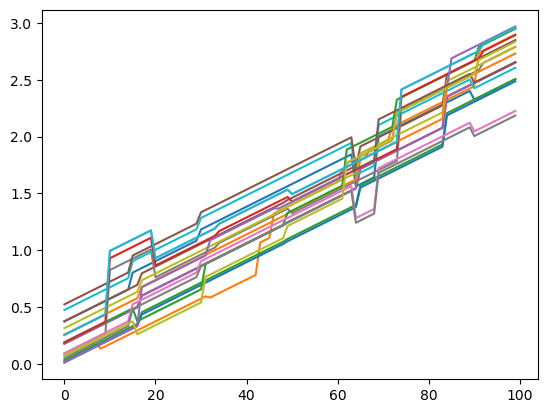

In [5]:
shock_episodes = np.empty((0, length))
for sigma_t in np.linspace(2, 7, 5):
    for sigma_shock in np.linspace(0.1, 0.3, 5):
        shock = RandomShockDegradation(length=length, dim=1, mu_t=15, sigma_t=sigma_t, mu_shock=0.2, sigma_shock=sigma_shock, baseline=True)
        
        episodes_i = shock.generate_episode(x0=np.abs(np.random.randn(n0)*0.5))  # Initial crack lengths in meters
        shock_episodes = np.concatenate([shock_episodes, episodes_i], axis=0)

#drop invalid values
shock_episodes = shock_episodes[~np.isnan(shock_episodes).any(axis=1)]
shock_episodes = shock_episodes[(shock_episodes<3).all(axis=1)]
shock_episodes = shock_episodes[(shock_episodes>=0).all(axis=1)]

shock_episodes.shape
# plot 20 random episodes
plt.plot(shock_episodes[np.random.randint(0, shock_episodes.shape[0], size=20)].T)
shock_episodes.min(), shock_episodes.max(), shock_episodes.shape

In [6]:
episodes = np.concatenate([lin_episodes, shock_episodes, paris_episodes], axis=0)

In [7]:

# Check default device
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
#device = torch.device('cpu')  # Force CPU for consistency in this example
print("Default Device:", device)

Default Device: mps


In [8]:
print(f"Min: {episodes.min()}")
print(f"Max: {episodes.max()}")

Min: 5.560583840149885e-07
Max: 2.9972916386513817


# Set up model and training params

In [9]:
vocab_size=400
context_window=50
bs = 64
# Split episodes into train/test (e.g., 80/20)
n_train = int(0.8 * len(episodes))
train_episodes = episodes[:n_train]
test_episodes = episodes[n_train:]
train_dataset = TimeSeriesDataset(train_episodes, context_window=context_window, vocab_size=vocab_size)
test_dataset = TimeSeriesDataset(test_episodes, context_window=context_window, vocab_size=vocab_size)
len(train_dataset), len(test_dataset)

(65200, 16350)

In [10]:
train_episodes.shape, test_episodes.shape

((1304, 100), (327, 100))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=2)
len(train_loader), len(test_loader)

(1019, 256)

In [12]:
model = DegradationTransformer(vocab_size=vocab_size, context_window=context_window, 
                               embedding_dim=64, num_heads=8, num_blocks=1)
optim = torch.optim.Adam(model.parameters(), lr=0.002)
loss_func = torch.nn.CrossEntropyLoss()
len(train_loader), len(test_loader)
cbs = [ProgressCallback(50)]
learner = Learner(model, optim, loss_func, train_loader, test_loader, cbs, device=device)
learner.fit(3)

y_predict shape: torch.Size([64, 400])
y_batch shape: torch.Size([64])
y_predict shape: torch.Size([64, 400])
y_batch shape: torch.Size([64])
y_predict shape: torch.Size([64, 400])
y_batch shape: torch.Size([64])
y_predict shape: torch.Size([64, 400])
y_batch shape: torch.Size([64])


KeyboardInterrupt: 

In [ ]:
learner.predict(test_episodes[58:60,:context_window], num_periods=60).shape

(2, 110)

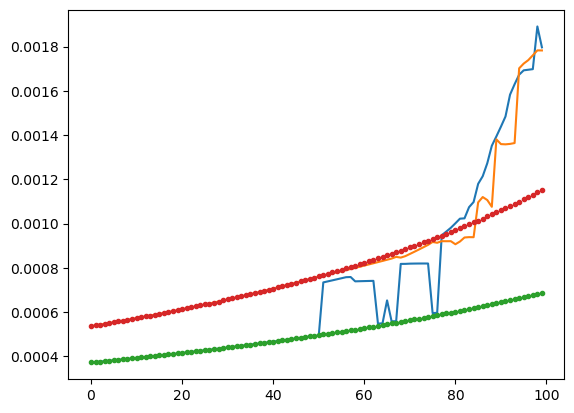

In [ ]:

plt.plot(learner.predict(test_episodes[59:61,:context_window], num_periods=50).T)
plt.plot(test_episodes[59:61, ].T, '.')



In [ ]:
batch = test_episodes[59:62,:5]
batch

array([[3.72046250e-04, 3.74044225e-04, 3.76058317e-04, 3.78088698e-04,
        3.80135545e-04],
       [5.36550970e-04, 5.40011250e-04, 5.43505058e-04, 5.47032828e-04,
        5.50595000e-04],
       [9.45102443e-05, 9.47660517e-05, 9.50228984e-05, 9.52807901e-05,
        9.55397323e-05]])

In [ ]:
class WindowNormalizer:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon
    
    def normalize(self, window, params=None):
        window = np.asarray(window)  # Ensure it's a numpy array
        if not params:
            params = {'min': window.min(-1)[...,None], 'max': window.max(-1)[...,None]}
        normalized = (window - params['min']) / (params['max'] - params['min'] + self.epsilon)
        
        return normalized, params
    
    def denormalize(self, normalized_value, params):
        return normalized_value * (params['max'] - params['min'] + self.epsilon) + params['min']

In [ ]:
class WindowNormalizer1d:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon
    
    def normalize(self, window, params=None):
        window = np.asarray(window)  # Ensure it's a numpy array
        if not params:
            params = {'min': window.min(), 'max': window.max()}
        normalized = (window - params['min']) / (params['max'] - params['min'] + self.epsilon)
        
        return normalized, params
    
    def denormalize(self, normalized_value, params):
        return normalized_value * (params['max'] - params['min'] + self.epsilon) + params['min']

In [ ]:
def test_normalizer_2d():
    normalizer = WindowNormalizer()
    window = np.array([[1, 2, 3], [4, 5, 6]])
    print("Original Window:\n", window)
    normalized, params = normalizer.normalize(window)
    print("Normalized Window:\n", normalized)
    print("params:\n", params['min'].shape)
    assert np.allclose(normalized[...,-1], 1), "normalization is not correct"
    assert np.allclose(normalized[...,0], 0), "normalization is not correct"
    denormalized = normalizer.denormalize(normalized, params)
    print("Denormalized Window:\n", denormalized)
    assert np.allclose(window, denormalized), "Denormalization did not return the original window"
    
    
def test_normalizer_1d():
    normalizer = WindowNormalizer()
    window = np.array([1, 2, 3])
    print("Original Window:\n", window)
    normalized, params = normalizer.normalize(window)
    print("Normalized Window:\n", normalized)
    print("params:\n", params['min'].shape)
    assert np.allclose(normalized[...,-1], 1), "normalization is not correct"
    assert np.allclose(normalized[...,0], 0), "normalization is not correct"
    denormalized = normalizer.denormalize(normalized, params)
    print("Denormalized Window:\n", denormalized)
    assert np.allclose(window, denormalized), "Denormalization did not return the original window"
    denormalized_0 = normalizer.denormalize(normalized[0], params)
    print("Denormalized row:\n", denormalized_0)
    assert np.allclose(window[0], denormalized_0), "Denormalization did not return the original element"
    
    

In [ ]:
test_normalizer_2d()

Original Window:
 [[1 2 3]
 [4 5 6]]
Normalized Window:
 [[0.  0.2 0.4]
 [0.6 0.8 1. ]]
params:
 ()


AssertionError: normalization is not correct

In [ ]:
test_normalizer_1d()

Original Window:
 [1 2 3]
Normalized Window:
 [0.  0.5 1. ]
params:
 ()
Denormalized Window:
 [1. 2. 3.]
Denormalized row:
 1.0


In [ ]:
norm_batch, p1 = WindowNormalizer().normalize(batch)

In [ ]:
norm_batch

array([[0.        , 0.23919662, 0.48540135, 0.73888963, 0.99995052],
       [0.        , 0.23898755, 0.48511573, 0.73867078, 0.99995337],
       [0.        , 0.23945973, 0.48576054, 0.73916457, 0.99994659]])

In [ ]:
WindowNormalizer().denormalize(norm_batch, p1)

array([[0.00248695, 0.00253529, 0.00258505, 0.00263628, 0.00268904],
       [0.00258592, 0.00263718, 0.00268996, 0.00274435, 0.00280038],
       [0.00236517, 0.00241001, 0.00245612, 0.00250357, 0.0025524 ]])

In [ ]:
batch

array([[0.00248695, 0.00253529, 0.00258505, 0.00263628, 0.00268904],
       [0.00258592, 0.00263718, 0.00268996, 0.00274435, 0.00280038],
       [0.00236517, 0.00241001, 0.00245612, 0.00250357, 0.0025524 ]])